In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["LANGCHAIN_API_KEY"]=os.environ.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="Q&A_over_Graph_data"

In [2]:
os.environ["NEO4J_URI"] = os.environ.get('NEO4J_URI')
os.environ["NEO4J_USERNAME"] = os.environ.get('NEO4J_USERNAME')
os.environ["NEO4J_PASSWORD"] = os.environ.get('NEO4J_PASSWORD')

In [3]:
from langchain_community.graphs import Neo4jGraph

graph = Neo4jGraph()

# Import movie information

movies_query = """
LOAD CSV WITH HEADERS FROM 
'https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/movies/movies_small.csv'
AS row
MERGE (m:Movie {id:row.movieId})
SET m.released = date(row.released),
    m.title = row.title,
    m.imdbRating = toFloat(row.imdbRating)
FOREACH (director in split(row.director, '|') | 
    MERGE (p:Person {name:trim(director)})
    MERGE (p)-[:DIRECTED]->(m))
FOREACH (actor in split(row.actors, '|') | 
    MERGE (p:Person {name:trim(actor)})
    MERGE (p)-[:ACTED_IN]->(m))
FOREACH (genre in split(row.genres, '|') | 
    MERGE (g:Genre {name:trim(genre)})
    MERGE (m)-[:IN_GENRE]->(g))
"""

graph.query(movies_query)

[]

# Graph schema
In order for an LLM to be able to generate a Cypher statement, it needs information about the graph schema. 

When you instantiate a graph object, it retrieves the information about the graph schema.

If you later make any changes to the graph, you can run the ```refresh_schema``` method to refresh the schema information.

In [5]:
graph.refresh_schema()
print(graph.schema)

Node properties:
Movie {id: STRING, released: DATE, title: STRING, imdbRating: FLOAT}
Person {name: STRING}
Genre {name: STRING}
Relationship properties:

The relationships:
(:Movie)-[:IN_GENRE]->(:Genre)
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:ACTED_IN]->(:Movie)


# Chain
Let's use a simple chain that takes a question, turns it into a Cypher query, executes the query, and uses the result to answer the original question.

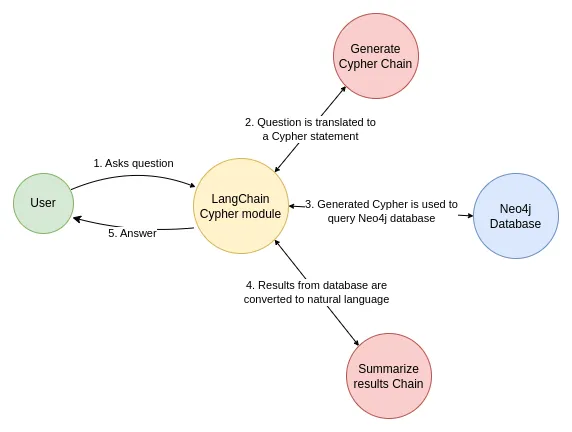

# GraphCypherQAChain

LangChain comes with a built-in chain for this workflow that is designed to work with Neo4j: GraphCypherQAChain



In [7]:
from langchain.chains import GraphCypherQAChain
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
chain = GraphCypherQAChain.from_llm(graph=graph, llm=llm, verbose=True)
response = chain.invoke({"query": "What was the cast of the Casino?"})
response



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person)-[:ACTED_IN]->(m:Movie {title: 'Casino'}) RETURN p.name
Full Context:
[{'p.name': 'Robert De Niro'}, {'p.name': 'Joe Pesci'}, {'p.name': 'Sharon Stone'}, {'p.name': 'James Woods'}]

> Finished chain.


{'query': 'What was the cast of the Casino?',
 'result': 'The cast of Casino includes Robert De Niro, Joe Pesci, Sharon Stone, and James Woods.'}

# Validating relationship direction

LLMs can struggle with relationship directions in generated Cypher statement. 

Since the graph schema is predefined, we can validate and optionally correct relationship directions in the generated Cypher statements by using the validate_cypher parameter.

In [8]:
chain = GraphCypherQAChain.from_llm(
    graph=graph, llm=llm, verbose=True, validate_cypher=True
)
response = chain.invoke({"query": "What was the cast of the Casino?"})
response



> Entering new GraphCypherQAChain chain...
Generated Cypher:

MATCH (p:Person)-[:ACTED_IN]->(m:Movie {title: 'Casino'}) RETURN p.name

Full Context:
[{'p.name': 'Robert De Niro'}, {'p.name': 'Joe Pesci'}, {'p.name': 'Sharon Stone'}, {'p.name': 'James Woods'}]

> Finished chain.


{'query': 'What was the cast of the Casino?',
 'result': 'The cast of Casino includes Robert De Niro, Joe Pesci, Sharon Stone, and James Woods.'}